# Analysis 2: XGBoost and Semi-Supervised XGBoost

## Load Libraries

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, average_precision_score, roc_curve, precision_recall_curve, auc
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import make_scorer, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.utils import resample
import seaborn as sns

np.random.seed(42)


# Loading Datasets

In [37]:
# Load the datasets
df_train = pd.read_csv('D_train.csv')
df_val = pd.read_csv('D_val.csv')

# Calculating Correlations & selecting Features


In [38]:
def select_train_cols(df, target_column, threshold=0.2):    
    # Calculate the correlation with the target variable
    label_corr = df.corr()[target_column]
    
    # Select columns with correlation above the threshold
    train_cols = label_corr[(~label_corr.isna()) & (np.abs(label_corr) > threshold)]
    train_cols = list(train_cols.index)
    
    return train_cols

In [39]:
train_cols = select_train_cols(df_train, 'fraud')

# train_cols.append('Labelled')

df_train_cols = df_train[train_cols]

train_cols

['fraud',
 "'M50039827'_sum",
 "'M1888755466'_max",
 "'M1888755466'_sum",
 "'M480139044'_max",
 "'M480139044'_std",
 "'M480139044'_count",
 "'M480139044'_sum",
 "'M840466850'_sum",
 "'M1741626453'_std",
 "'M1741626453'_count",
 "'M1741626453'_sum",
 "'M1535107174'_sum",
 "'M2122776122'_max",
 "'M2122776122'_std",
 "'M2122776122'_count",
 "'M2122776122'_sum",
 "'M1873032707'_max",
 "'M1873032707'_std",
 "'M1873032707'_count",
 "'M1873032707'_sum",
 "'M2011752106'_max",
 "'M2011752106'_mean",
 "'M2011752106'_median",
 "'M2011752106'_std",
 "'M2011752106'_count",
 "'M2011752106'_sum",
 "'M857378720'_std",
 "'M857378720'_count",
 "'M857378720'_sum",
 "'M1198415165'_max",
 "'M1198415165'_count",
 "'M1198415165'_sum",
 "'M980657600'_max",
 "'M980657600'_std",
 "'M980657600'_count",
 "'M980657600'_sum",
 "'M547558035'_max",
 "'M547558035'_std",
 "'M547558035'_count",
 "'M547558035'_sum",
 "'M17379832'_max",
 "'M17379832'_std",
 "'M17379832'_count",
 "'M17379832'_sum",
 "'M923029380'_count",
 

In [40]:
num_rows = len(df_train_cols)
unlabelled_values = np.random.choice([0, 1], size=num_rows, p=[0.5, 0.5])
df_train_cols['Labelled'] = unlabelled_values
df_train_cols

/tmp/ipykernel_192024/60489751.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_cols['Labelled'] = unlabelled_values


,fraud,'M50039827'_sum,'M1888755466'_max,'M1888755466'_sum,'M480139044'_max,'M480139044'_std,'M480139044'_count,'M480139044'_sum,'M840466850'_sum,'M1741626453'_std,...,'es_leisure'_max,'es_leisure'_mean,'es_leisure'_median,'es_leisure'_std,'es_leisure'_count,'es_leisure'_sum,category_frequency,merchant_frequency,amount_log,Labelled
0,0,-0.193143,-0.243131,-0.229441,2.934064,-0.277417,0.211311,0.771682,-0.368362,-0.081963,...,-0.246187,-0.247342,-0.247277,-0.107288,-0.189722,-0.180289,0.077467,-1.919028,-0.779650,0
1,0,-0.193143,-0.243131,-0.229441,-0.386785,-0.277417,-0.290308,-0.218117,-0.368362,-0.081963,...,-0.246187,-0.247342,-0.247277,-0.107288,-0.189722,-0.180289,-2.271491,-1.919028,0.213308,1
2,0,-0.193143,-0.243131,-0.229441,-0.386785,-0.277417,-0.290308,-0.218117,-0.368362,-0.081963,...,-0.246187,-0.247342,-0.247277,-0.107288,-0.189722,-0.180289,0.312363,0.299356,-0.738566,1
3,0,-0.193143,-0.243131,-0.229441,3.149942,3.008618,1.214548,2.343511,5.089803,-0.081963,...,-0.246187,-0.247342,-0.247277,-0.107288,-0.189722,-0.180289,0.899603,1.075791,0.103452,1
4,0,-0.193143,6.619753,5.299477,3.816500,4.256655,3.221023,5.342679,3.180184,-0.081963,...,5.894705,4.680477,4.839599,10.151894,7.282900,8.686959,-0.392325,-0.698916,-2.129834,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356749,0,-0.193143,3.299419,2.624530,-0.386785,-0.277417,-0.290308,-0.218117,0.134384,-0.081963,...,-0.246187,-0.247342,-0.247277,-0.107288,-0.189722,-0.180289,0.312363,0.521195,0.975132,1
356750,1,-0.193143,0.989820,0.763856,1.345375,-0.277417,0.211311,0.298164,-0.082739,-0.081963,...,4.887399,5.221173,5.210876,-0.107288,1.678434,2.279758,-2.388939,-2.029947,2.576613,1
356751,0,-0.193143,-0.243131,-0.229441,-0.386785,-0.277417,-0.290308,-0.218117,1.614606,-0.081963,...,-0.246187,-0.247342,-0.247277,-0.107288,-0.189722,-0.180289,-2.388939,-2.029947,1.109687,0
356752,0,-0.193143,-0.243131,-0.229441,-0.386785,-0.277417,-0.290308,-0.218117,1.267948,-0.081963,...,-0.246187,-0.247342,-0.247277,-0.107288,-0.189722,-0.180289,-2.271491,-2.029947,0.333940,1


# Creating Datasets per percentage fraud

In [42]:
import pandas as pd

def create_datasets(df, percentages, sample_size_normal=15000, unlabelled_normal_size=5000, random_state=42):
    datasets = {}
    
    unlabelled_fraud = df[(df['fraud'] == 1) & (df['Labelled'] == 0)]
    unlabelled_normal = df[(df['fraud'] == 0) & (df['Labelled'] == 0)]
    labelled_fraud = df[(df['fraud'] == 1) & (df['Labelled'] == 1)]
    labelled_normal = df[(df['fraud'] == 0) & (df['Labelled'] == 1)]
    
    sample_labelled_normal = labelled_normal.sample(n=sample_size_normal, random_state=random_state)
    sample_unlabelled_normal = unlabelled_normal.sample(n=unlabelled_normal_size, random_state=random_state)
    
    for p in percentages:
        size_fraud = int(len(unlabelled_fraud) * p)
        
        sample_unlabelled_fraud = unlabelled_fraud.iloc[:size_fraud]
        sample_labelled_fraud = labelled_fraud.iloc[:size_fraud]
        
        full_df = pd.concat([sample_labelled_normal, sample_unlabelled_normal, sample_unlabelled_fraud, sample_labelled_fraud])
        
        dataset_name = f'D_train_{p}p'
        datasets[dataset_name] = full_df
        
    return datasets

# Define the percentages
percentages = [0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.010, 0.011]

# Create the datasets
datasets = create_datasets(df_train_cols, percentages)

# Access the dataset for a specific percentage, e.g., 0.01
D_train_0_04p = datasets['D_train_0.004p']
D_train_0_05p = datasets['D_train_0.005p']
D_train_0_06p = datasets['D_train_0.006p']
D_train_0_07p = datasets['D_train_0.007p']
D_train_0_08p = datasets['D_train_0.008p']
D_train_0_09p = datasets['D_train_0.009p']
D_train_0_1p = datasets['D_train_0.01p']
D_train_0_11p = datasets['D_train_0.011p']

----

## Calculating Baseline

### Function for calculating baseline

In [44]:
def evaluate_baseline_model(df, fraud_probability):
    y_true = df['fraud']
    
    np.random.seed(42)  
    y_pred = np.random.choice([0, 1], size=len(y_true), p=[1 - fraud_probability, fraud_probability])
    
    print("Unique values in y_true after filtering:", np.unique(y_true))
    
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    
    precision_values, recall_values, _ = precision_recall_curve(y_true, y_pred)
    auc_pr = auc(recall_values, precision_values)
    
    return  auc_pr, precision, recall 


### Excecute baseline per dataset

In [46]:
datasets = [D_train_0_04p, D_train_0_05p, D_train_0_06p, D_train_0_07p, D_train_0_08p, D_train_0_09p, D_train_0_1p, D_train_0_11p]
dataset_names = ['0.04', '0.05', '0.06', '0.07', '0.08', '0.09', '0.1' ,'0.11'] 

results_baseline = []

# Loop through each dataset
for i, df_train in enumerate(datasets):
    print(f"Processing dataset {i+1}/{len(datasets)}: {dataset_names[i]}")
    auc_pr, precision, recall = evaluate_baseline_model(df_train, float(dataset_names[i]))    
    results_baseline.append({'Dataset': dataset_names[i], 'AUC-PR': auc_pr, 'Precision': precision, 'Recall': recall})
    
results_baseline_df = pd.DataFrame(results_baseline)

Processing dataset 1/8: 0.04
Unique values in y_true after filtering: [0 1]
Processing dataset 2/8: 0.05
Unique values in y_true after filtering: [0 1]
Processing dataset 3/8: 0.06
Unique values in y_true after filtering: [0 1]
Processing dataset 4/8: 0.07
Unique values in y_true after filtering: [0 1]
Processing dataset 5/8: 0.08
Unique values in y_true after filtering: [0 1]
Processing dataset 6/8: 0.09
Unique values in y_true after filtering: [0 1]
Processing dataset 7/8: 0.1
Unique values in y_true after filtering: [0 1]
Processing dataset 8/8: 0.11
Unique values in y_true after filtering: [0 1]


### Results Baseline

In [47]:
results_baseline_df

,Dataset,AUC-PR,Precision,Recall
0,0.04,0.032258,0.001267,0.062500
1,0.05,0.051449,0.001998,0.100000
2,0.06,0.043043,0.001654,0.083333
3,0.07,0.037063,0.001399,0.071429
4,0.08,0.030828,0.001236,0.058824
5,0.09,0.027775,0.001122,0.052632
6,0.1,0.025311,0.001008,0.047619
7,0.11,0.045435,0.001819,0.086957


-----

# XGBoost

### Algorithm to excecute Isolation Forest

In [48]:
def train_and_evaluate_xgb(df_train, df_val, params, num_boost_round=100):
    # Ensure the same columns in both training and validation datasets
    common_cols = list(set(df_train.columns) & set(df_val.columns))
    df_train = df_train[common_cols]
    df_val = df_val[common_cols]

    # Remove the 'fraud' column to create feature matrices
    X_train = df_train.drop(columns=['fraud'])
    y_train = df_train['fraud']
    X_val = df_val.drop(columns=['fraud'])
    y_val = df_val['fraud']

    # Create DMatrix for training and validation
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_val, label=y_val)

    # Train the model
    model = xgb.train(params, dtrain, num_boost_round=num_boost_round)

    # Predict probabilities
    y_pred_prob = model.predict(dval)

    # Calculate Precision-Recall AUC
    precision, recall, _ = precision_recall_curve(y_val, y_pred_prob)
    auc_pr = auc(recall, precision)

    # Determine the threshold for binary classification
    threshold = len(df_train[df_train['fraud'] == 1]) / len(df_train)
    y_pred = (y_pred_prob >= threshold).astype(int)

    # Calculate Precision and Recall
    precision_score_val = precision_score(y_val, y_pred, zero_division=0)
    recall_score_val = recall_score(y_val, y_pred, zero_division=0)

    return auc_pr, precision_score_val, recall_score_val

### XGBoost Parameters

In [49]:
# XGBoost parameters
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'aucpr',
    'max_depth': 6,
    'eta': 0.1,
    'seed': 42
}

### Excecute on every dataset with Labelled = 1 to only select the labelled instances

In [50]:
D_train_0_04p_label = D_train_0_04p[D_train_0_04p['Labelled'] == 1]
D_train_0_05p_label = D_train_0_05p[D_train_0_05p['Labelled'] == 1]
D_train_0_06p_label = D_train_0_06p[D_train_0_06p['Labelled'] == 1]
D_train_0_07p_label = D_train_0_07p[D_train_0_07p['Labelled'] == 1]
D_train_0_08p_label = D_train_0_08p[D_train_0_08p['Labelled'] == 1]
D_train_0_09p_label = D_train_0_09p[D_train_0_09p['Labelled'] == 1]
D_train_0_1p_label = D_train_0_1p[D_train_0_1p['Labelled'] == 1]
D_train_0_11p_label = D_train_0_11p[D_train_0_11p['Labelled'] == 1]

datasets = [D_train_0_04p_label,D_train_0_05p_label, D_train_0_06p_label, D_train_0_07p_label, D_train_0_08p_label, D_train_0_09p_label, D_train_0_1p_label, D_train_0_11p_label] 
dataset_names = ['0.04', '0.05', '0.06', '0.07', '0.08', '0.09', '0.1' ,'0.11']

In [54]:
results_xgb = []

# Loop through each dataset
for i, df_train in enumerate(datasets):
    print(f"Processing dataset {i+1}/{len(datasets)}: {dataset_names[i]}")
    auc_pr, precision, recall = train_and_evaluate_xgb(df_train, df_val, best_params_xgb)
    results_xgb.append({'Dataset': dataset_names[i], 'AUC-PR': auc_pr, 'Precision': precision, 'Recall': recall})

# Create a DataFrame to store the results
results_xgb_df = pd.DataFrame(results_xgb)

Processing dataset 1/8: 0.04
Processing dataset 2/8: 0.05
Processing dataset 3/8: 0.06
Processing dataset 4/8: 0.07
Processing dataset 5/8: 0.08
Processing dataset 6/8: 0.09
Processing dataset 7/8: 0.1
Processing dataset 8/8: 0.11


### Results XGBoost on Validation Set

In [57]:
results_xgb_df

,Dataset,AUC-PR,Precision,Recall
0,0.04,0.532587,0.365285,0.685417
1,0.05,0.541253,0.374562,0.668750
2,0.06,0.546079,0.406598,0.659028
3,0.07,0.530890,0.404470,0.640972
4,0.08,0.541254,0.423250,0.654861
5,0.09,0.554303,0.430049,0.663889
6,0.1,0.571150,0.473764,0.652083
7,0.11,0.568065,0.470473,0.669444


----

# Semi-supervised XGB

### Algorithm for Semi-Supervised XGBoost

In [58]:
import xgboost as xgb
import numpy as np
import pandas as pd
from sklearn.metrics import precision_recall_curve, auc, precision_score, recall_score

def self_learning_xgboost(df_train, L0, U0, df_val, params, MaxIter=256, T=0.1, num_boost_round=100):
    """
    Self-learning XGBoost algorithm with evaluation phase.
    
    Parameters:
    L0 : ndarray
        Initial set of labelled training instances.
    U0 : ndarray
        Initial set of unlabelled training instances.
    df_val : DataFrame
        Validation dataset for evaluation.
    params : dict
        Parameters for the XGBoost model.
    MaxIter : int, optional
        Maximum number of iterations for self-training.
    T : float, optional
        Percentage of instances to accept per iteration.
    num_boost_round : int, optional
        Number of boosting rounds for XGBoost.
    
    Returns:
    dict
        Evaluation metrics (AUC-PR, Precision, Recall).
    """
    
    # Initialize labelled and unlabelled sets
    Li = L0.copy()
    Ui = U0.copy()
    
    original_columns = Li.columns
    label_dtype = Li.iloc[:, 0].dtype
    
    # Extract features and labels from the initial labelled set
    X_Li = Li.iloc[:, 1:]
    y_Li = Li.iloc[:, 0]
    
    # Train initial XGBoost model
    dtrain = xgb.DMatrix(X_Li, label=y_Li)
    model = xgb.train(params, dtrain, num_boost_round=num_boost_round)
    
    # Self-training iterations
    for i in range(MaxIter):
        if len(Ui) == 0:
            break
        
        # Predict on unlabelled set
        X_Ui = Ui.iloc[:, 1:]
        dtest = xgb.DMatrix(X_Ui)
        preds = model.predict(dtest)
        
        # Sort predictions by confidence
        sorted_indices = np.argsort(preds)[::-1]
        sorted_Ui = Ui.iloc[sorted_indices]
        sorted_preds = preds[sorted_indices]
        
        # Select top T% most confident predictions
        num_to_select = int(T * len(L0))
        selected_Ui = sorted_Ui.iloc[:num_to_select].copy()
        selected_preds = sorted_preds[:num_to_select]
        
        # Add selected instances to labelled set
        selected_Ui.iloc[:, 0] = selected_preds.astype(label_dtype)
        Li = pd.concat([Li, selected_Ui])
        
        # Remove selected instances from unlabelled set
        Ui = sorted_Ui.iloc[num_to_select:]
        
        # Retrain XGBoost model on augmented labelled set
        X_Li = Li.iloc[:, 1:]
        y_Li = Li.iloc[:, 0]
        dtrain = xgb.DMatrix(X_Li, label=y_Li)
        model = xgb.train(params, dtrain, num_boost_round=num_boost_round)
    
    # Ensure the final DataFrame has the correct column names
    Li.columns = original_columns

    

    # # Evaluate the final model
    auc_pr, precision, recall = train_and_evaluate_xgb(Li, df_val, params, num_boost_round)
    
    return {'AUC-PR': auc_pr, 'Precision': precision, 'Recall': recall}

def train_and_evaluate_xgb(df_train, df_val, params, num_boost_round=100):
    """
    Train and evaluate XGBoost model.
    
    Parameters:
    df_train : DataFrame
        Training dataset.
    df_val : DataFrame
        Validation dataset.
    params : dict
        Parameters for the XGBoost model.
    num_boost_round : int, optional
        Number of boosting rounds.
    
    Returns:
    tuple
        AUC-PR, Precision, Recall.
    """
    
    common_cols = list(set(df_train.columns) & set(df_val.columns))
    df_val = df_val[common_cols]
    
    # Remove the 'fraud' column to create feature matrices
    X_train = df_train[common_cols].drop(columns = ['fraud'])
    y_train = df_train['fraud']
    X_val = df_val.drop(columns = ['fraud'])
    y_val = df_val['fraud']

    # Create DMatrix for training and validation
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_val, label=y_val)

    # Train the model
    model = xgb.train(params, dtrain, num_boost_round=num_boost_round)

    # Predict probabilities
    y_pred_prob = model.predict(dval)

    # Calculate Precision-Recall AUC
    precision, recall, _ = precision_recall_curve(y_val, y_pred_prob)
    auc_pr = auc(recall, precision)

    # Determine the threshold for binary classification
    threshold = len(df_train[df_train['fraud'] == 1]) / len(df_train)
    y_pred = (y_pred_prob >= threshold).astype(int)

    # Calculate Precision and Recall
    precision_score_val = precision_score(y_val, y_pred, zero_division=0)
    recall_score_val = recall_score(y_val, y_pred, zero_division=0)

    return auc_pr, precision_score_val, recall_score_val


In [60]:
print(D_train_0_04p.shape)

(20016, 95)


### Excecuting Semi-supervised XGBoost for all datasets

In [59]:
datasets = [D_train_0_04p, D_train_0_05p, D_train_0_06p, D_train_0_07p, D_train_0_08p, D_train_0_09p, D_train_0_1p, D_train_0_11p] 
dataset_names = ['0.04', '0.05', '0.06', '0.07', '0.08', '0.09', '0.1' ,'0.11'] 

results_ss_xgb = []

# Loop through each dataset
for i, df_train in enumerate(datasets):
    print(f"Processing dataset {i+1}/{len(datasets)}: {dataset_names[i]}")
    L0 = df_train[df_train['Labelled'] == 1]
    U0 = df_train[df_train['Labelled'] == 0]
    evaluation_metrics = self_learning_xgboost(df_train, L0, U0, df_val, params)
    evaluation_metrics['Dataset'] = dataset_names[i]
    results_ss_xgb.append(evaluation_metrics)

# Create a DataFrame to store the results
results_ss_xgb_df = pd.DataFrame(results_ss_xgb)

Processing dataset 1/8: 0.04
Processing dataset 2/8: 0.05
Processing dataset 3/8: 0.06
Processing dataset 4/8: 0.07
Processing dataset 5/8: 0.08
Processing dataset 6/8: 0.09
Processing dataset 7/8: 0.1
Processing dataset 8/8: 0.11


### Results of semi-supervised XGBoost

In [63]:
results_ss_xgb_df

,AUC-PR,Precision,Recall,Dataset
0,0.569438,0.337715,0.749306,0.04
1,0.571999,0.357264,0.732639,0.05
2,0.569456,0.387585,0.711111,0.06
3,0.572949,0.408035,0.719444,0.07
4,0.588210,0.426765,0.726389,0.08
5,0.589022,0.423681,0.730556,0.09
6,0.580868,0.422853,0.755556,0.1
7,0.572750,0.435664,0.731250,0.11


----

# Final Results Analysis 2

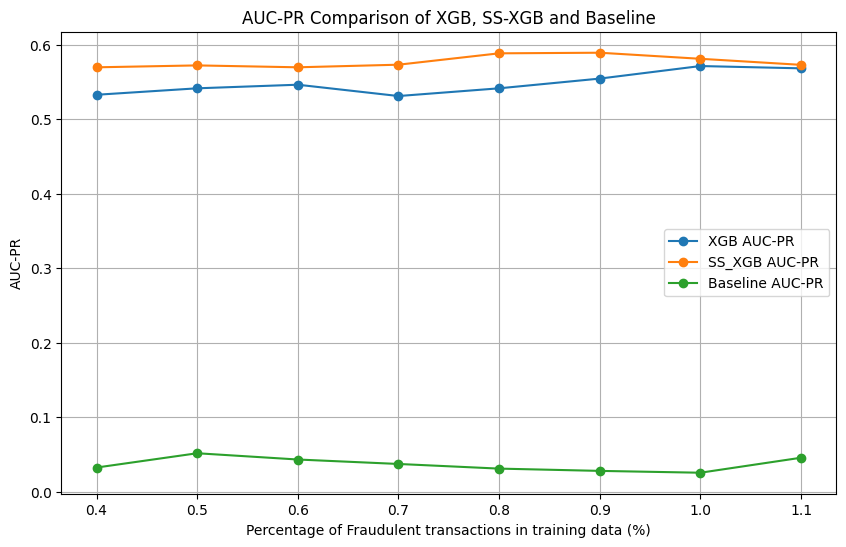

In [90]:
custom_labels = ['0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1.0', '1.1']

# Plotting the AUC-PR results for both models in one graph
plt.figure(figsize=(10, 6))

plt.plot(results_xgb_df['Dataset'], results_xgb_df['AUC-PR'], marker='o', label='XGB AUC-PR')
plt.plot(results_ss_xgb_df['Dataset'], results_ss_xgb_df['AUC-PR'], marker='o', label='SS_XGB AUC-PR')
plt.plot(results_baseline_df['Dataset'],results_baseline_df['AUC-PR'], marker='o', label='Baseline AUC-PR')
plt.title('AUC-PR Comparison of XGB, SS-XGB and Baseline')
plt.xlabel('Percentage of Fraudulent transactions in training data (%)')
plt.ylabel('AUC-PR')
plt.xticks(ticks=results_ss_xgb_df['Dataset'], labels=custom_labels)  # Adding custom x-axis labels
plt.legend()
plt.grid(True)
plt.show()

---

# Results on Test set

### Read test set

In [66]:
df_test = pd.read_csv('D_test.csv')

### Test results XGBoost

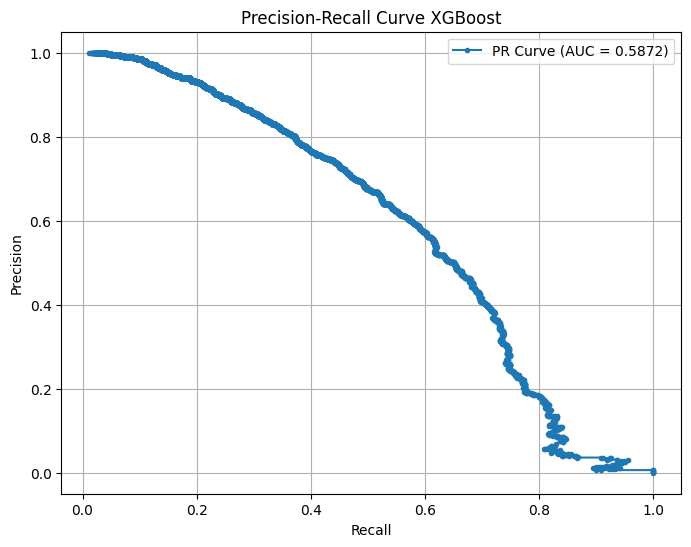

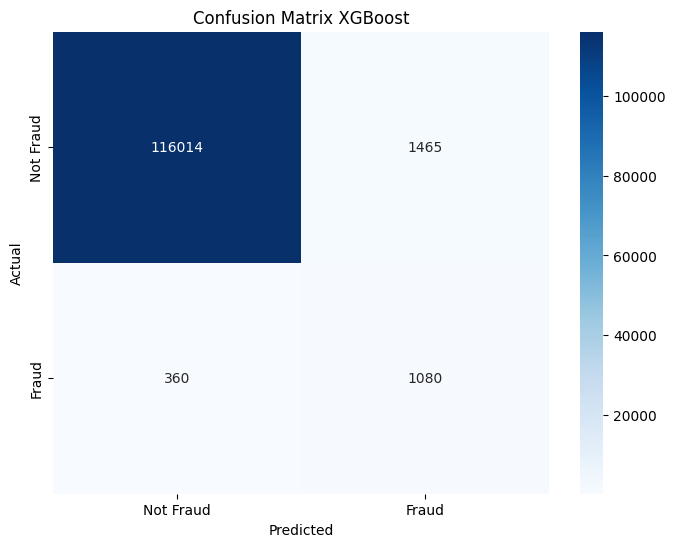

In [89]:

def train_and_evaluate_xgb(df_train, df_val, params, num_boost_round=100):
    # Ensure the same columns in both training and validation datasets
    common_cols = list(set(df_train.columns) & set(df_val.columns))
    df_train = df_train[common_cols]
    df_val = df_val[common_cols]

    # Remove the 'fraud' column to create feature matrices
    X_train = df_train.drop(columns=['fraud'])
    y_train = df_train['fraud']
    X_val = df_val.drop(columns=['fraud'])
    y_val = df_val['fraud']

    # Create DMatrix for training and validation
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_val, label=y_val)

    # Train the model
    model = xgb.train(params, dtrain, num_boost_round=num_boost_round)

    # Predict probabilities
    y_pred_prob = model.predict(dval)

    # Calculate Precision-Recall AUC
    precision, recall, _ = precision_recall_curve(y_val, y_pred_prob)
    auc_pr = auc(recall, precision)

    # Determine the threshold for binary classification
    threshold = len(df_train[df_train['fraud'] == 1]) / len(df_train)
    y_pred = (y_pred_prob >= threshold).astype(int)

    # Calculate Precision and Recall
    precision_score_val = precision_score(y_val, y_pred, zero_division=0)
    recall_score_val = recall_score(y_val, y_pred, zero_division=0)

    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_val, y_pred)

    # Plot Precision-Recall curve
    plt.figure(figsize=(8, 6))
    plt.plot(precision, recall, marker='.', label='PR Curve (AUC = {:.4f})'.format(auc_pr))
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve XGBoost')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot confusion matrix as heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix XGBoost')
    plt.show()

    return 

# Example usage:
# df_train and df_val should be your training and validation DataFrames
# params should be your XGBoost parameters
train_and_evaluate_xgb(D_train_0_1p_label, df_test, params)


### Test results semi-supervised XGBoost

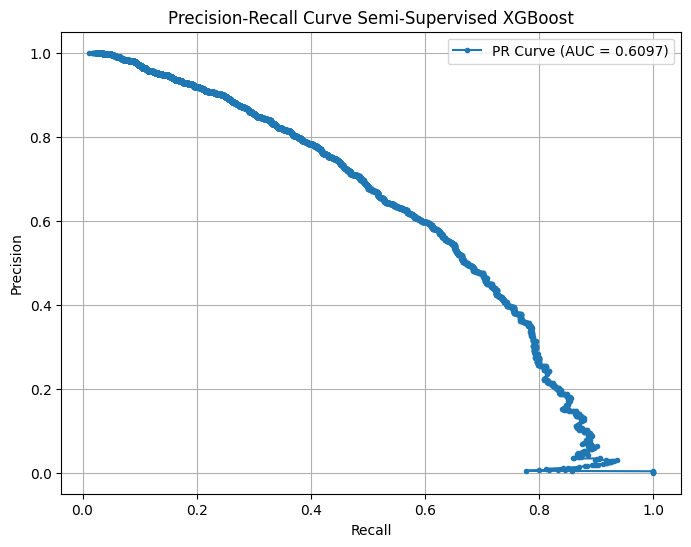

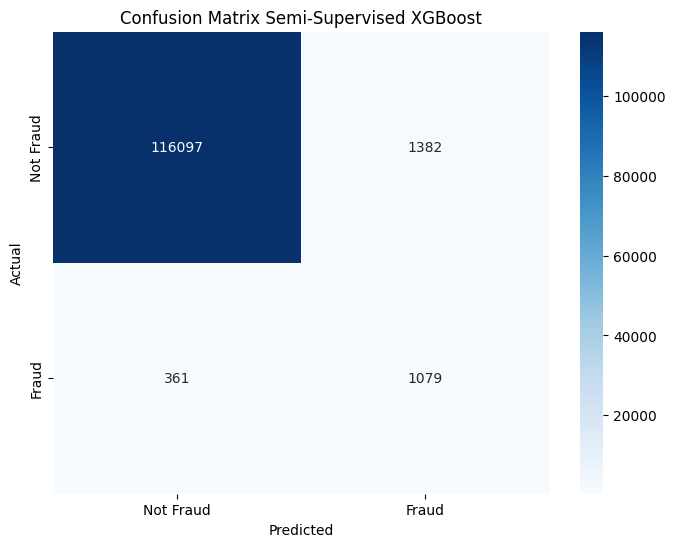

In [88]:
import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_curve, auc, precision_score, recall_score, confusion_matrix

def self_learning_xgboost(df_train, L0, U0, df_val, params, MaxIter=256, T=0.1, num_boost_round=100):
    """
    Self-learning XGBoost algorithm with evaluation phase.
    
    Parameters:
    L0 : DataFrame
        Initial set of labelled training instances.
    U0 : DataFrame
        Initial set of unlabelled training instances.
    df_val : DataFrame
        Validation dataset for evaluation.
    params : dict
        Parameters for the XGBoost model.
    MaxIter : int, optional
        Maximum number of iterations for self-training.
    T : float, optional
        Percentage of instances to accept per iteration.
    num_boost_round : int, optional
        Number of boosting rounds for XGBoost.
    
    Returns:
    dict
        Evaluation metrics (AUC-PR, Precision, Recall).
    """
    
    # Initialize labelled and unlabelled sets
    Li = L0.copy()
    Ui = U0.copy()
    
    original_columns = Li.columns
    label_dtype = Li.iloc[:, 0].dtype
    
    # Extract features and labels from the initial labelled set
    X_Li = Li.iloc[:, 1:]
    y_Li = Li.iloc[:, 0]
    
    # Train initial XGBoost model
    dtrain = xgb.DMatrix(X_Li, label=y_Li)
    model = xgb.train(params, dtrain, num_boost_round=num_boost_round)
    
    # Self-training iterations
    for i in range(MaxIter):
        if len(Ui) == 0:
            break
        
        # Predict on unlabelled set
        X_Ui = Ui.iloc[:, 1:]
        dtest = xgb.DMatrix(X_Ui)
        preds = model.predict(dtest)
        
        # Sort predictions by confidence
        sorted_indices = np.argsort(preds)[::-1]
        sorted_Ui = Ui.iloc[sorted_indices]
        sorted_preds = preds[sorted_indices]
        
        # Select top T% most confident predictions
        num_to_select = int(T * len(L0))
        selected_Ui = sorted_Ui.iloc[:num_to_select].copy()
        selected_preds = sorted_preds[:num_to_select]
        
        # Add selected instances to labelled set
        selected_Ui.iloc[:, 0] = selected_preds.astype(label_dtype)
        Li = pd.concat([Li, selected_Ui])
        
        # Remove selected instances from unlabelled set
        Ui = sorted_Ui.iloc[num_to_select:]
        
        # Retrain XGBoost model on augmented labelled set
        X_Li = Li.iloc[:, 1:]
        y_Li = Li.iloc[:, 0]
        dtrain = xgb.DMatrix(X_Li, label=y_Li)
        model = xgb.train(params, dtrain, num_boost_round=num_boost_round)
    
    # Ensure the final DataFrame has the correct column names
    Li.columns = original_columns

    # Evaluate the final model
    auc_pr, precision_score_val, recall_score_val, conf_matrix = train_and_evaluate_xgb(Li, df_val, params, num_boost_round)
    
    return {
        "AUC-PR": auc_pr,
        "Precision": precision_score_val,
        "Recall": recall_score_val,
        "Confusion Matrix": conf_matrix
    }

def train_and_evaluate_xgb(df_train, df_val, params, num_boost_round=100):
    """
    Train and evaluate XGBoost model.
    
    Parameters:
    df_train : DataFrame
        Training dataset.
    df_val : DataFrame
        Validation dataset.
    params : dict
        Parameters for the XGBoost model.
    num_boost_round : int, optional
        Number of boosting rounds.
    
    Returns:
    tuple
        AUC-PR, Precision, Recall, Confusion Matrix.
    """
    
    common_cols = list(set(df_train.columns) & set(df_val.columns))
    df_val = df_val[common_cols]
    
    # Remove the 'fraud' column to create feature matrices
    X_train = df_train[common_cols].drop(columns=['fraud'])
    y_train = df_train['fraud']
    X_val = df_val.drop(columns=['fraud'])
    y_val = df_val['fraud']

    # Create DMatrix for training and validation
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_val, label=y_val)

    # Train the model
    model = xgb.train(params, dtrain, num_boost_round=num_boost_round)

    # Predict probabilities
    y_pred_prob = model.predict(dval)

    # Calculate Precision-Recall AUC
    precision, recall, _ = precision_recall_curve(y_val, y_pred_prob)
    auc_pr = auc(recall, precision)

    # Determine the threshold for binary classification
    threshold = len(df_train[df_train['fraud'] == 1]) / len(df_train)
    y_pred = (y_pred_prob >= threshold).astype(int)

    # Calculate Precision and Recall
    precision_score_val = precision_score(y_val, y_pred, zero_division=0)
    recall_score_val = recall_score(y_val, y_pred, zero_division=0)
    
    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_val, y_pred)

    # Plot Precision-Recall curve
    plt.figure(figsize=(8, 6))
    plt.plot(precision, recall, marker='.', label='PR Curve (AUC = {:.4f})'.format(auc_pr))
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve Semi-Supervised XGBoost')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot confusion matrix as heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix Semi-Supervised XGBoost')
    plt.show()

    return auc_pr, precision_score_val, recall_score_val, conf_matrix


L0 = D_train_0_09p[D_train_0_09p['Labelled'] == 1]
U0 = D_train_0_09p[D_train_0_09p['Labelled'] == 0]
evaluation_metrics = self_learning_xgboost(D_train_0_09p, L0, U0, df_test, params)